In [ ]:
#%%

# 0 impots
"""A2_GenerativeModels.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/16j1EOOp_2butQUNu1EV97VL6a5SioDwt

# Introduction to Deep Learning

<div style="text-align: right">   </div>


Introduction to Deep Learning (2024) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 1, Part 3: Generative Models** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">


In this notebook we are going to cover two generative models for generating novel images:

1. Variational Autoencoders (**VAEs**)
2. Generative adversarial networks (**GANs**)


<img src="https://lilianweng.github.io/lil-log/assets/images/three-generative-models.png" width="500">


Your main goal will be to retrain these models on a dataset of your choice and do some experiments on the learned latent space.

You should first copy this notebook and enable GPU runtime in 'Runtime -> Change runtime type -> Hardware acceleration -> GPU **OR** TPU'.
"""

# !pip install 'tensorflow[and-gpu]'==2.14 ##

from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2024-12-09 12:17:37.827795: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 12:17:37.845592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 12:17:37.854080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 12:17:37.856801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 12:17:37.863574: I tensorflow/core/platform/cpu_feature_guar

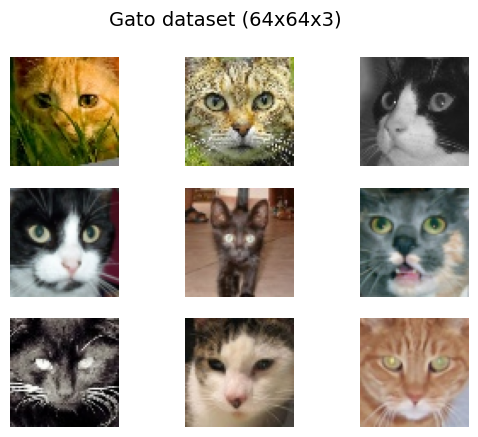

In [ ]:
#%%

# 1 data
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True) ## If you want to use your google drive

# !wget https://surfdrive.surf.nl/files/index.php/s/62Lnr1AtGe9b0v9/download -O face_dataset_64x64.npy

"""
### Dataset

This dataset is called [Flickr-Faces-HQ Dataset](https://github.com/NVlabs/ffhq-dataset). Here we will use a downsampled version of it (64x64x3) that will speed up all the experiments. [Download](https://surfdrive.surf.nl/files/index.php/s/LXBrnGGvUISlckW).

After downloading you should copy it to your google drive's main directory (or modify the code to load it from elsewhere).

After running the notebook on this default dataset you then need to find a dataset of your own."""

def load_real_samples(scale=False):
    # We load 20,000 samples only to avoid memory issues, you can  change this value
    X = np.load('images_64x64.npy',  fix_imports=True,encoding='latin1')[:20000, :, :, :]
    # Scale samples in range [-127, 127]
    if scale:
        X = (X - 127.5) * 2
    return X / 255.

# We will use this function to display the output of our models throughout this notebook
def grid_plot(images, epoch='', name='', n=3, save=False, scale=False):
    if scale:
        images = (images + 1) / 2.0
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + '  '+ str(epoch), fontsize=14)
    if save:
        filename = 'results/generated_plot_e%03d_f.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()
    plt.show()


dataset = load_real_samples()
grid_plot(dataset[np.random.randint(0, 1000, 9)], name='Gato dataset (64x64x3)', n=3)

In [ ]:
#%%

# 2 model
"""## 2.1. Introduction

The generative models that we are going to cover both have the following components:

1. A downsampling architecture (encoder in case of VAE, and discriminator in case of GAN) to either extract features from the data or model its distribution.
2. An upsampling architecture (decoder for VAE, generator for GAN) that will use some kind of latent vector to generate new samples that resemble the data that it was trained on.

Since we are going to be dealing with images, we are going to use convolutional networks for upsampling and downsampling, similar to what you see below.

<img src="https://i2.wp.com/sefiks.com/wp-content/uploads/2018/03/convolutional-autoencoder.png" width="500">


#### Code for building these components:
"""

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape

def build_conv_net(in_shape, out_shape, n_downsampling_layers=4, filters=128, out_activation='sigmoid'):
    """
    Build a basic convolutional network
    """
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    input = tf.keras.Input(shape=in_shape)
    x = Conv2D(filters=filters, name='enc_input', **default_args)(input)

    for _ in range(n_downsampling_layers):
        x = Conv2D(**default_args, filters=filters)(x)

    x = Flatten()(x)
    x = Dense(out_shape, activation=out_activation, name='enc_output')(x)

    model = tf.keras.Model(inputs=input, outputs=x, name='Encoder')

    model.summary()
    return model


def build_deconv_net(latent_dim, n_upsampling_layers=4, filters=128, activation_out='sigmoid'):
    """
    Build a deconvolutional network for decoding/upscaling latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that
    were used in the downsampling network and the Conv2DTranspose layers are used instead of Conv2D layers.
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    shape of our input images.
    """
    input = tf.keras.Input(shape=(latent_dim,))
    x = Dense(4 * 4 * 64, input_dim=latent_dim, name='dec_input')(input)
    x = Reshape((4, 4, 64))(x) # This matches the output size of the downsampling architecture

    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    for i in range(n_upsampling_layers):
        x = Conv2DTranspose(filters=filters, **default_args)(x)

    # This last convolutional layer converts back to 3 channel RGB image
    x = Conv2D(filters=3, kernel_size=(3,3), padding='same', activation=activation_out, name='dec_output')(x)

    model = tf.keras.Model(inputs=input, outputs=x, name='Decoder')
    model.summary()
    return model

In [ ]:
#%% 

# VAE
"""*Note: You may experiment with the latent dimensionality and number of filters in your convolutional network to see how it affects the reconstruction quality. Remember that this also affects the size of the model and time it takes to train.*

---
---


## 2. 2. Variational Autoencoders (VAEs)

<img src="https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png" width="500">

#### Encoder network
This defines the approximate posterior distribution, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation. In this example, we simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. We output log-variance instead of the variance directly for numerical stability.

#### Decoder network
This defines the conditional distribution of the observation $z$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation. We model the latent distribution prior  as a unit Gaussian.

#### Reparameterization trick
To generate a sample  for the decoder during training, we can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $z$. However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, we use a reparameterization trick. In our example, we approximate  using the decoder parameters and another parameter  as follows:

$$z = \mu + \sigma\epsilon$$

where $\mu$ and $\sigma$  represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The  can be thought of as a random noise used to maintain stochasticity of $z$. We generate  from a standard normal distribution.

The latent variable  is now generated by a function of $\mu$ and $\sigma$ which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

#### Implementation

You can see how this trick is implemented below by creating a custom layer by sublassing tf.keras.layers.Layer.
It is then connected to the output of the original encoder architecture and an additional [KL](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) loss term is introduced.
"""

class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon

def build_vae(data_shape, latent_dim, filters=128):

    # Building the encoder - starts with a simple downsampling convolutional network
    encoder = build_conv_net(data_shape, latent_dim*2, filters=filters)

    # Adding special sampling layer that uses the reparametrization trick
    z_mean = Dense(latent_dim)(encoder.output)
    z_var = Dense(latent_dim)(encoder.output)
    z = Sampling()([z_mean, z_var])

    # Connecting the two encoder parts
    encoder = tf.keras.Model(inputs=encoder.input, outputs=z)

    # Defining the decoder which is a regular upsampling deconvolutional network
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters)
    vae = tf.keras.Model(inputs=encoder.input, outputs=decoder(z))

    # Define a custom layer for the KL loss calculation
    class KLLossLayer(tf.keras.layers.Layer):
        def call(self, inputs):
            z_mean, z_var = inputs
            kl_loss = -0.5 * tf.reduce_sum(z_var - tf.square(z_mean) - tf.exp(z_var) + 1)
            # Add the KL loss to the model's losses
            self.add_loss(kl_loss / tf.cast(tf.keras.backend.prod(data_shape), tf.float32))
            return inputs  # Pass through the inputs unchanged

    # Apply the custom layer to z_mean and z_var
    _, _ = KLLossLayer()([z_mean, z_var])

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')

    return encoder, decoder, vae

I0000 00:00:1733743070.760601  979737 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733743070.788788  979737 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733743070.788891  979737 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733743070.790461  979737 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_input (Conv2D)              │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_output (Dense)              │ (None, 128)            │        65,664 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 659,584 (2.52 MB)

 Trainable params: 659,584 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

/vol/home/s4398831/workspace/leiden/S1/IDL/2024/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_input (Dense)               │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_output (Conv2D)             │ (None, 64, 64, 3)      │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 586,627 (2.24 MB)

 Trainable params: 586,627 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1733743073.729024  979902 service.cc:146] XLA service 0x7768a0016b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733743073.729047  979902 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-12-09 12:17:53.770162: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-09 12:17:53.957637: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  37/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.6872

I0000 00:00:1733743076.807995  979902 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.6091


W0000 00:00:1733743088.774020  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743088.786602  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743088.787235  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743088.787876  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743088.788525  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743088.789191  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743088.789815  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743088.790444  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743088.791079  979737 gp

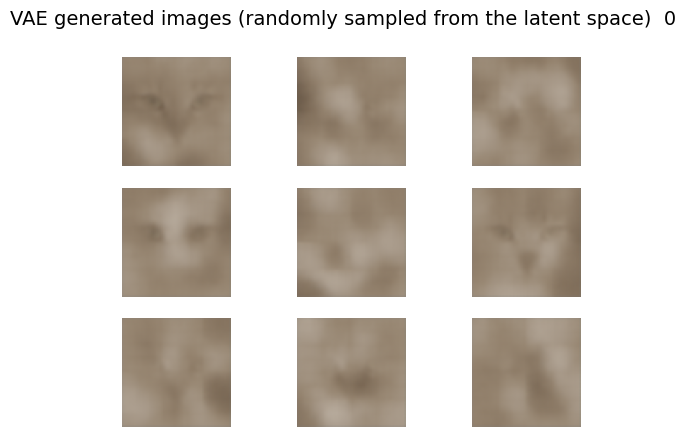

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5725
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5645
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5614
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5603
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5588


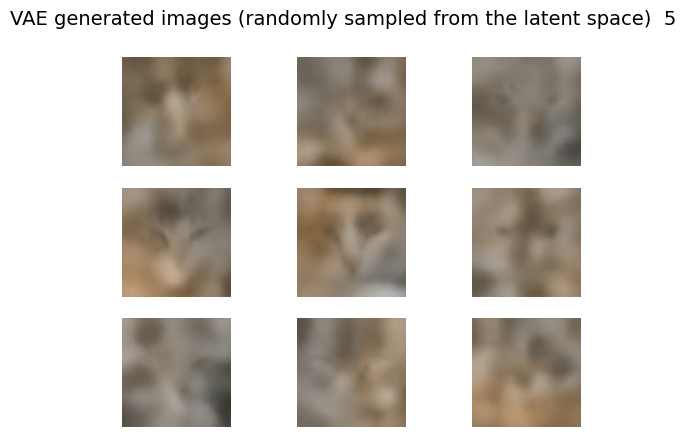

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5578
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5555
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5567
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5553
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5553


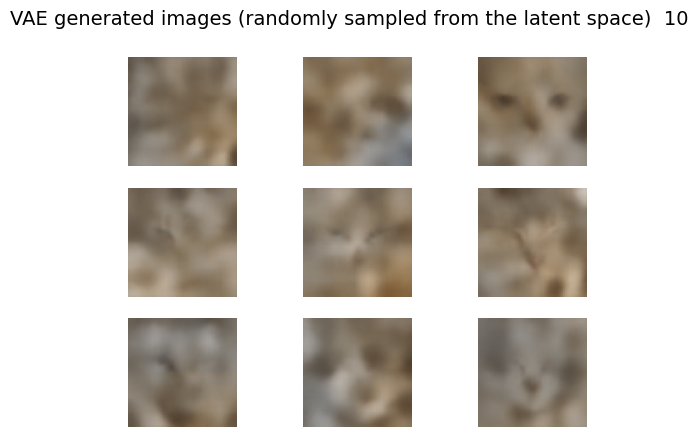

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5555
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5542
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5546
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5528
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5542


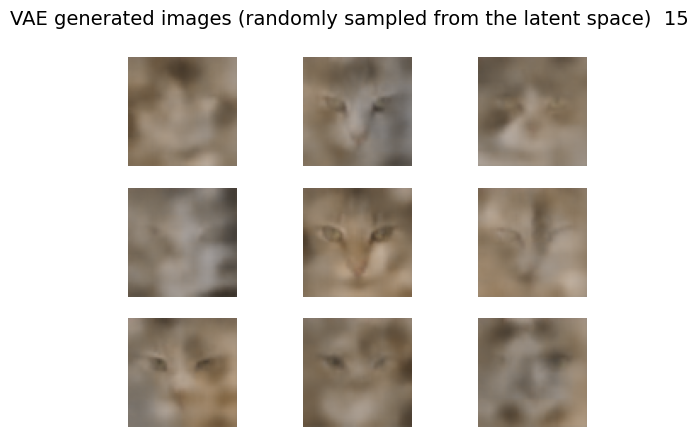

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5536
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5540
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5539
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5530
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.5527


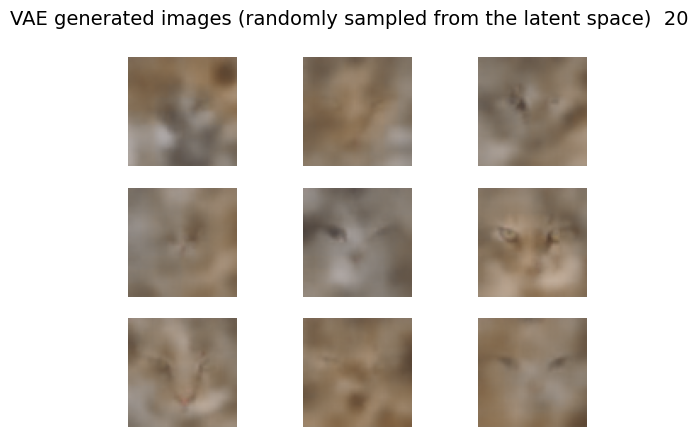

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5528
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5520
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5526
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5527
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.5526


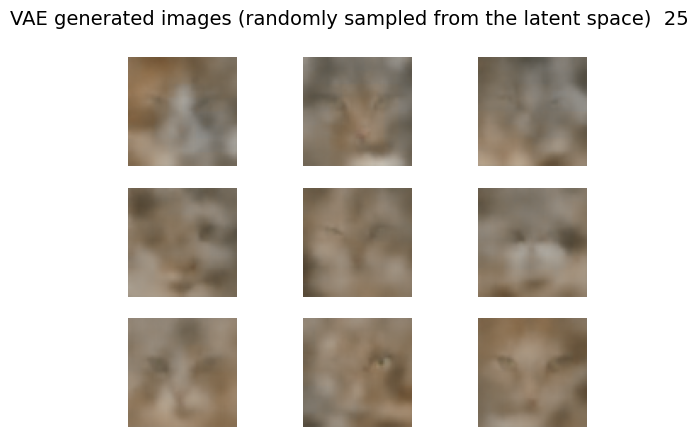

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5516
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5513
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5517
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5527
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5510


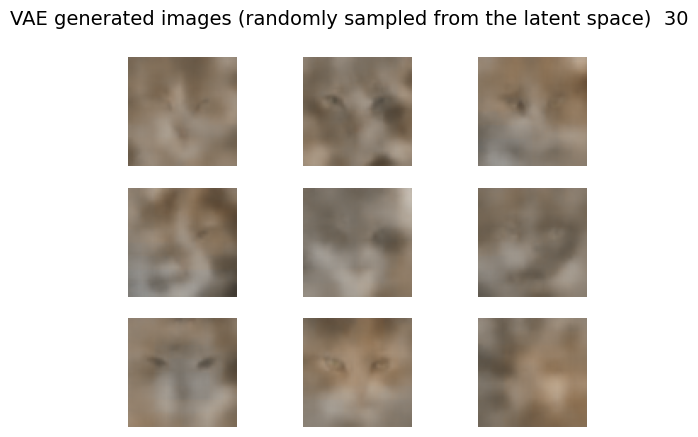

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5521
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5523
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5519
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5514
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5506


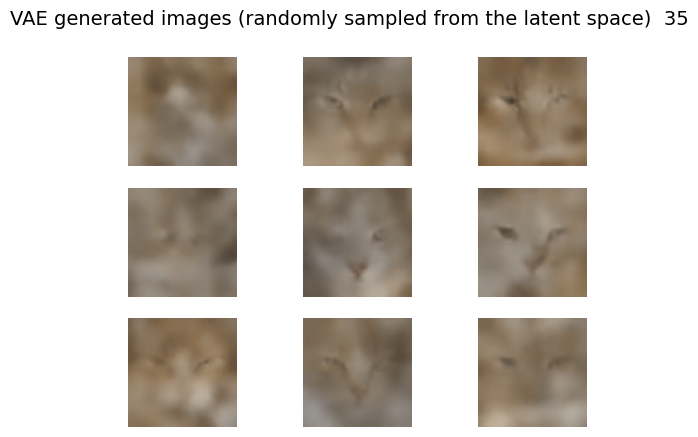

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5517
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5506
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5524
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5511
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5507


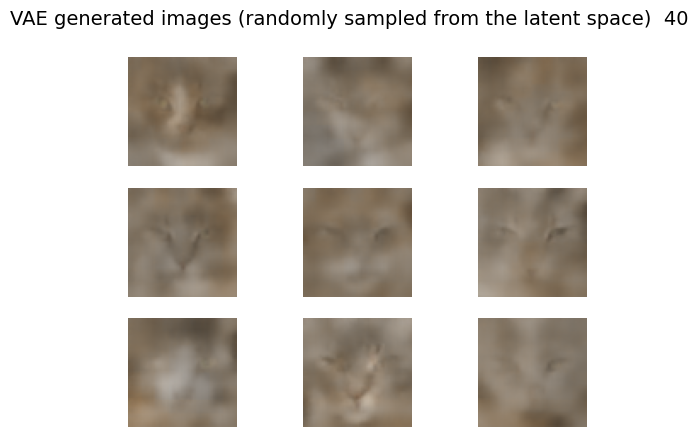

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.5516
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5510
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.5513
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5513
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5514


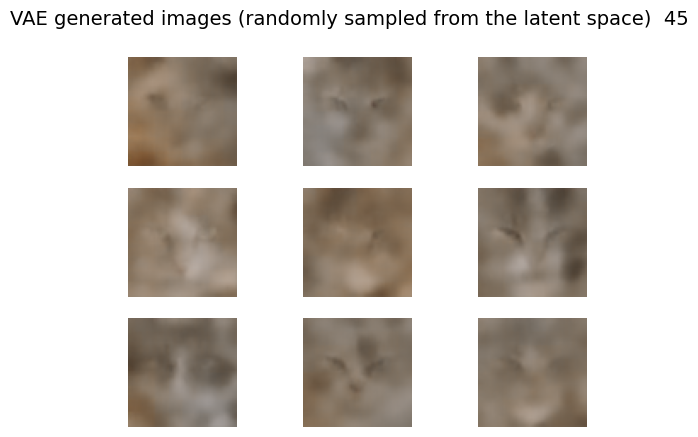

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5516
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5514
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5509
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.5510


In [ ]:
#%% 

# Training the VAE model

latent_dim = 64 
encoder, decoder, vae = build_vae(dataset.shape[1:], latent_dim, filters=128)

for epoch in range(50):
    vae.fit(x=dataset, y=dataset, epochs=1, batch_size=8)

    # Generate random vectors that we will use to sample from the learned latent space
    latent_vectors = np.random.randn(9, latent_dim)/6 ## You can tweak this coefficient to increase/decrease the std of the sampled vectors
    images = decoder(latent_vectors)
    if epoch%5==0:
        grid_plot(images, epoch, name='VAE generated images (randomly sampled from the latent space)', n=3, save=False)

In [ ]:
#%% extract encoder & run for batch

encoder = vae.layers[1:-4]
fm = dataset[:64]
for l in encoder:
    fm = l(fm)
    print(fm.shape)
m = vae.layers[-4](fm)
s = vae.layers[-3](fm)
values = np.array(m)
sam = Sampling()
results = sam.call([m,s])

W0000 00:00:1733743703.926231  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743703.927226  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743703.928118  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743703.929120  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743703.930294  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743703.931462  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743703.932647  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743703.933866  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743703.934874  979737 gp

(64, 32, 32, 128)
(64, 16, 16, 128)
(64, 8, 8, 128)
(64, 4, 4, 128)
(64, 2, 2, 128)
(64, 512)
(64, 128)


W0000 00:00:1733743704.129045  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743704.129768  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743704.130442  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743704.131111  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743704.131795  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743704.132474  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743704.133144  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743704.133846  979737 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733743704.134519  979737 gp

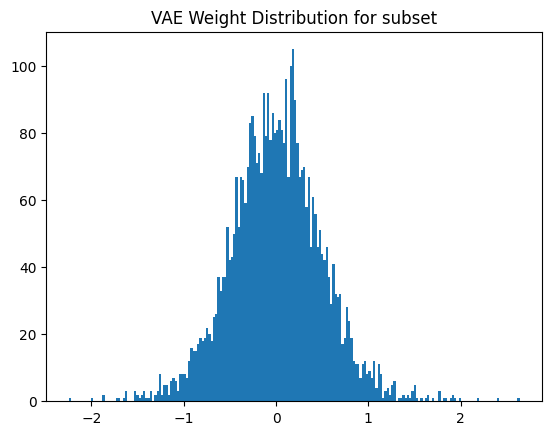

In [ ]:
#%% find distribution

plt.hist(np.array(results).flatten(),bins=200)
plt.title("VAE Weight Distribution for subset")
# plt.show()
plt.savefig("VAE_sample_dist.png")

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_input (Dense)               │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_output (Conv2D)             │ (None, 64, 64, 3)      │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 586,627 (2.24 MB)

 Trainable params: 586,627 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


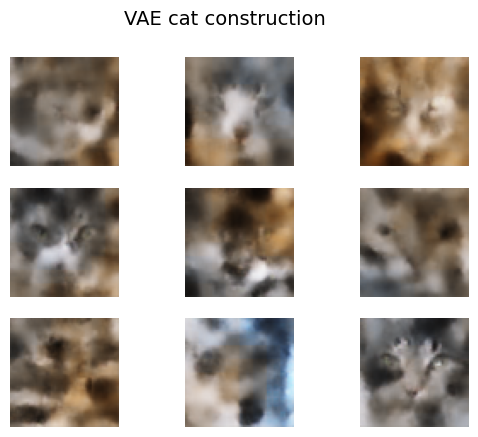

In [ ]:
#%% extract decoder

decoder = vae.layers[-1]
input_shape = decoder.input_shape[1:]
decoder.summary()
a = 0.5
random_data = 2*a*np.random.random(size=(9,*input_shape))-a
random_data = np.random.normal(0,0.5,size=(9,*input_shape))
pred = decoder.predict(random_data)
grid_plot(pred,name=f'VAE cat construction') 